In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

In [2]:
file_path = "merged_CICIDS2017.csv"
data = pd.read_csv(file_path)

In [3]:
# Display basic dataset information
print("Original Dataset shape:", data.shape)

Original Dataset shape: (2830743, 79)


In [4]:
# Handle Missing Values
missing_values = data.isnull().sum()
print("Missing values per column:\n\n", missing_values)

# Fill missing values with the median for numerical columns
data = data.fillna(data.median())

# Remove duplicates
data = data.drop_duplicates()
print("Dataset shape after removing duplicates:", data.shape)

# Inspect column names to identify the correct target column
print("Column names in the dataset:", data.columns)

# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Set the correct target column name
target_column = "Label"

# Encode target labels
label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])


Missing values per column:

  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64
Dataset shape after removing duplicates: (2522362, 79)
Column names in the dataset: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Ma

In [5]:
# Separate features and target
X = data.drop(columns=[target_column])  # Features
y = data[target_column]                # Target

In [6]:
# Check for infinity or very large values
print("Contains Inf values:", np.isinf(X).any().any())
print("Contains NaN values:", np.isnan(X).any().any())

Contains Inf values: True
Contains NaN values: False


In [7]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with column mean (or median)
X.fillna(X.mean(), inplace=True)

In [8]:
print("Contains Inf values (after fix):", np.isinf(X).any().any())
print("Contains NaN values (after fix):", np.isnan(X).any().any())

Contains Inf values (after fix): False
Contains NaN values (after fix): False


In [9]:
# Encode target labels if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize data (Chi-square test requires non-negative values)
X_normalized = X.abs()  # Ensures all values are non-negative

# Perform Chi-square feature selection
k = 10  # Number of top features to select
chi2_selector = SelectKBest(score_func=chi2, k=k)
X_selected = chi2_selector.fit_transform(X_normalized, y_encoded)
selected_features_chi = X.columns[chi2_selector.get_support()]

print("Top 10 Features selected using Chi-Square:")
print(selected_features_chi)

Top 10 Features selected using Chi-Square:
Index(['Flow Duration', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total',
       'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Max', 'Idle Mean', 'Idle Max',
       'Idle Min'],
      dtype='object')


In [10]:
# Random Forest

Accuracy: 0.94222217523513
Precision: 0.9287720480289612
Recall: 0.94222217523513
F1 Score: 0.9262076157343239


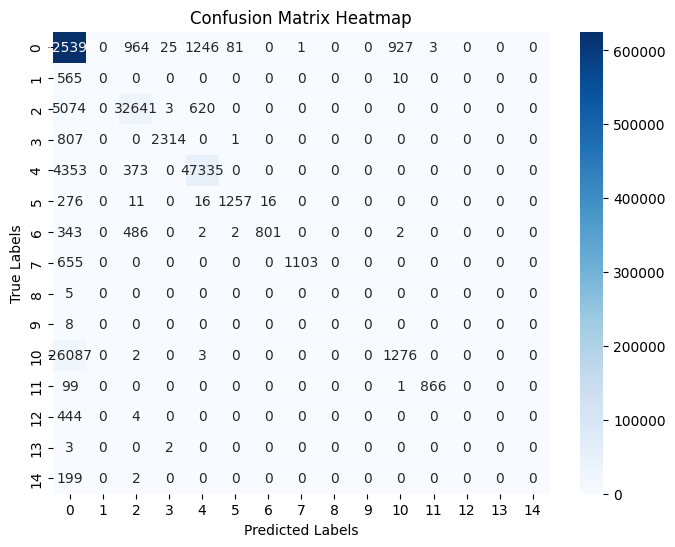

In [12]:
# Replace negative values with zero (or add a constant to shift all values to be non-negative)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = np.where(X_train < 0, 0, X_train)
X_test = np.where(X_test < 0, 0, X_test)

# Chi-Square Feature Selection
selector_chi2 = SelectKBest(score_func=chi2, k=10)
X_train_selected_chi2 = selector_chi2.fit_transform(X_train, y_train)
X_test_selected_chi2 = selector_chi2.transform(X_test)

# Train Random Forest
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf_classifier.fit(X_train_selected_chi2, y_train)

# Predictions and evaluation metrics
y_pred = rf_classifier.predict(X_test_selected_chi2)

# Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)


# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
# AdaBoost 

Accuracy: 0.7378543138775936
Precision: 0.6795684065644606
Recall: 0.7378543138775936
F1 Score: 0.7075129714332927


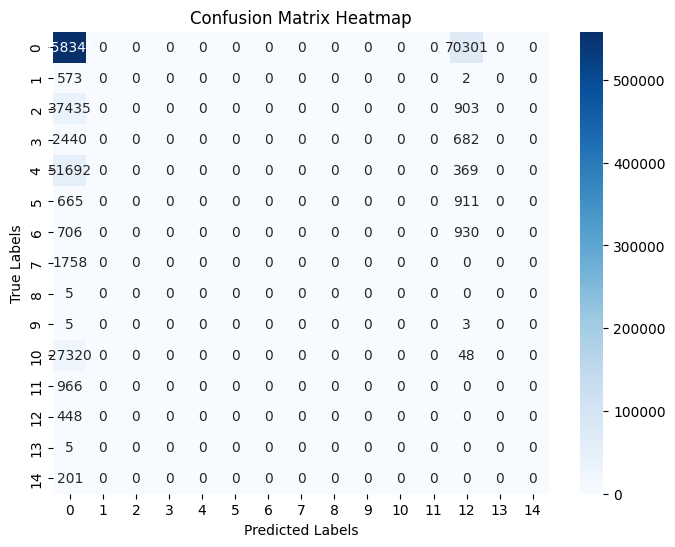

In [13]:
# Ensure all feature values are non-negative
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Replace negative values with zero (or add a constant to shift all values to be non-negative)
X_train = np.where(X_train < 0, 0, X_train)
X_test = np.where(X_test < 0, 0, X_test)

# Chi-Square Feature Selection
selector_chi2 = SelectKBest(score_func=chi2, k=10)
X_train_selected_chi2 = selector_chi2.fit_transform(X_train, y_train)
X_test_selected_chi2 = selector_chi2.transform(X_test)

# Train the AdaBoost classifier
adaboost_classifier_chi2 = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_classifier_chi2.fit(X_train_selected_chi2, y_train)

# Predictions and evaluation metrics
y_pred = adaboost_classifier_chi2.predict(X_test_selected_chi2)

# Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)


# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()